In [26]:
import torch
from d2l import torch as d2l
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator

## Autoregressive Models

Our target data will be a synthetic data set built on the sinusoidal function
SIN.

We create 1000 data points within the DATA class but corrupt their values by adding some random noise.

self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2


We first define some initialization parameters:

Batch size=16

T=1000 (size of the sequence)

num_train (training samples)

tau = 4 (4 points will be used to estimate our next sample) (Markov problem of order 4)



In [27]:
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2

Let's verify the type of structure we are using (Torch Tensors)
and print the created data.

<class 'torch.Tensor'>
<class 'torch.Tensor'>


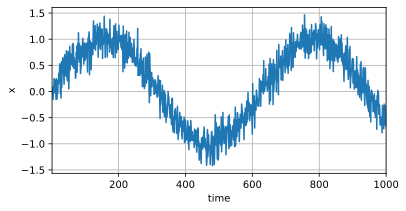

In [28]:
data = Data()
print(type(data.time))
print(type(data.x))
d2l.plot(data.time.detach().numpy(), data.x.detach().numpy(), 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

To begin, we try a model that acts as if
the data satisfied a $\tau^{\textrm{th}}$-order Markov condition,
and thus predicts $x_t$ using only the past $\tau$ observations. (We set it up originally to 4, you should try other values as well).

[**Thus for each time step we have an example
with label $y  = x_t$ and features
$\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$.**]


In [29]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    features = [self.x[i: self.T-self.tau+i] for i in range(self.tau)]
    self.features = torch.stack(features, 1)
    self.labels = self.x[self.tau:].reshape((-1, 1))
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)

In this example our model will be a simple standard linear regression.
You can consult early chapters of the book "Dive into DL" (D2l)  to see some more details of it.
At this moment, we are not much interesting on the model used. We will
analyze relevant models later.

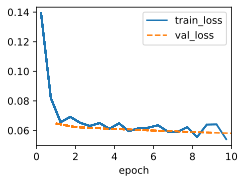

In [30]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

## Prediction

To evaluate our model, we first check
how well it performs at one-step-ahead prediction.

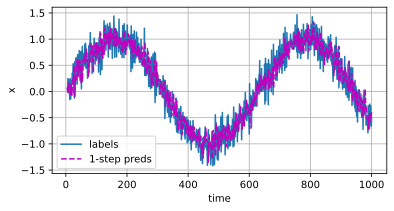

In [31]:
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))

These predictions look good,
even near the end at $t=1000$.

But what if we only observed sequence data
up until time step 604 (`n_train + tau`)
and wished to make predictions several steps
into the future?
Unfortunately, we cannot directly compute
the one-step-ahead prediction for time step 609,
because we do not know the corresponding inputs,
having seen only up to $x_{604}$.
We can address this problem by plugging in
our earlier predictions as inputs to our model
for making subsequent predictions,
projecting forward, one step at a time,
until reaching the desired time step:

$$\begin{aligned}
\hat{x}_{605} &= f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} &= f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} &= f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} &= f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} &= f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
&\vdots\end{aligned}$$

Generally, for an observed sequence $x_1, \ldots, x_t$,
its predicted output $\hat{x}_{t+k}$ at time step $t+k$
is called the $k$*-step-ahead prediction*.
Since we have observed up to $x_{604}$,
its $k$-step-ahead prediction is $\hat{x}_{604+k}$.
In other words, we will have to
keep on using our own predictions
to make multistep-ahead predictions.
Let's see how well this goes.


In [32]:
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(multistep_preds[i - data.tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

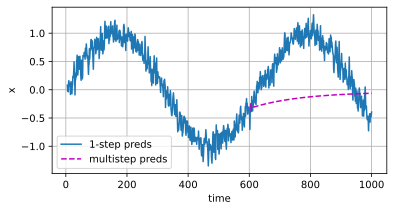

In [33]:
d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))

Unfortunately, in this case we fail spectacularly.
The predictions decay to a constant
pretty quickly after a few steps.
Why did the algorithm perform so much worse
when predicting further into the future?
Ultimately, this is down to the fact
that errors build up.
Let's say that after step 1 we have some error $\epsilon_1 = \bar\epsilon$.
Now the *input* for step 2 is perturbed by $\epsilon_1$,
hence we suffer some error in the order of
$\epsilon_2 = \bar\epsilon + c \epsilon_1$
for some constant $c$, and so on.
The predictions can diverge rapidly
from the true observations.
You may already be familiar
with this common phenomenon.
For instance, weather forecasts for the next 24 hours
tend to be pretty accurate but beyond that,
accuracy declines rapidly.
We will discuss methods for improving this
throughout this chapter and beyond.

Let's [**take a closer look at the difficulties in $k$-step-ahead predictions**]
by computing predictions on the entire sequence for $k = 1, 4, 16, 64$.


In [34]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i: i+data.T-data.tau-k+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(torch.stack(features[i: i+data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

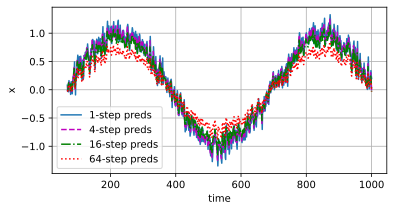

In [35]:
steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))

This clearly illustrates how the quality of the prediction changes
as we try to predict further into the future.
While the 4-step-ahead predictions still look good,
anything beyond that is starts to get worse.

# Ejercicio 1: Incorporar diferente número de observaciones anteriores (Tau) en las series y comparar resultados, graficando el error en función de Tau.

In [36]:
tau_train_losses = {}
tau_val_losses = {}

loss_fn = torch.nn.MSELoss()
max_tau = 0

best_val_loss = float('inf')
best_tau = None
best_state_dict = None

for tau in range(1, max_tau):
    data = Data(tau=tau)
    model = d2l.LinearRegression(lr=0.01)
    trainer = d2l.Trainer(max_epochs=10)
    trainer.fit(model, data)

    with torch.no_grad():
        preds_all = model(data.features)
        labels_all = data.labels

    train_idx = slice(0, data.num_train)
    val_idx   = slice(data.num_train, None)

    train_loss = loss_fn(preds_all[train_idx], labels_all[train_idx]).item()
    val_loss   = loss_fn(preds_all[val_idx],   labels_all[val_idx]).item()

    tau_train_losses[tau] = train_loss
    tau_val_losses[tau]   = val_loss

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_tau = tau
        best_state_dict = model.state_dict()

if max_tau > 0:
    rows = [
        {"tau": tau, "train_loss": tau_train_losses[tau], "val_loss": tau_val_losses[tau]}
        for tau in tau_train_losses
    ]
    df = pd.DataFrame(rows)
    df.to_csv("tau_losses_sin.csv", index=False)

    with open("best_tau_sin.txt", "w") as f:
        f.write(f"best_tau={best_tau}\nbest_val_loss={best_val_loss}\n")

    torch.save(best_state_dict, "best_model_sin.pt")

Para escoger un tau óptimo, tomamos como candidatos los taus cuya val_loss es menor a 5% por encima del mínimo. Y dentro de estos, escogemos el tau con menor valor.
De esta manera, tenemos un compromiso entre el menor error y el número de valores necesarios para la predicción.

In [37]:
df = pd.read_csv("tau_losses_sin.csv")

taus = df["tau"].tolist()
train_losses = df["train_loss"].tolist()
val_losses   = df["val_loss"].tolist()

min_val_loss = min(val_losses)
best_val_loss = min(val_losses)
best_tau = taus[val_losses.index(best_val_loss)]

print("Mejor Tau absoluto")
print("--------------------------------")
print(f"best_tau = {best_tau}, best_val = {best_val_loss:.4f}")
print("--------------------------------\n")

alpha = 0.05
threshold = min_val_loss * (1 + alpha)

mask = df["val_loss"] <= threshold
candidates_df = df[mask]

best_row = candidates_df.loc[candidates_df["tau"].idxmin()]
best_tau = int(best_row["tau"])
best_val = float(best_row["val_loss"])

print("Tau óptimo con umbral")
print("--------------------------------")
print(f"threshold = {threshold:.4f}")
print(f"best_tau = {best_tau}, best_val = {best_val:.4f}")
print("--------------------------------")

Mejor Tau absoluto
--------------------------------
best_tau = 49, best_val = 0.0420
--------------------------------

Tau óptimo con umbral
--------------------------------
threshold = 0.0441
best_tau = 5, best_val = 0.0435
--------------------------------


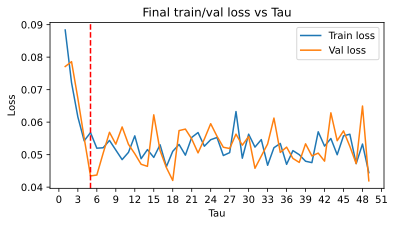

In [38]:
plt.plot(taus, train_losses, label='Train loss')
plt.plot(taus, val_losses,   label='Val loss')

plt.xlabel('Tau')
plt.ylabel('Loss')
plt.title('Final train/val loss vs Tau')
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=25))
plt.axvline(best_tau, color='red', linestyle='--', label=f'Best tau = {best_tau}')
plt.show()

Observamos que el tau óptimo es 5. Aunque el menor valor de pérdida sobre el conjunto de validación se alcanza cuando tau es
49, con tau = 5 obtenemos una pérdida dentro de un 5% del mínimo, lo cual nos indica que no es necesario tomar tantos
valores para obtener una buena predicción.

Una vez hemos obtenido el tau óptimo, podemos usarlo para hacer predicciones multistep.

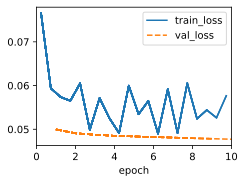

In [39]:
data = Data(tau=best_tau)
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

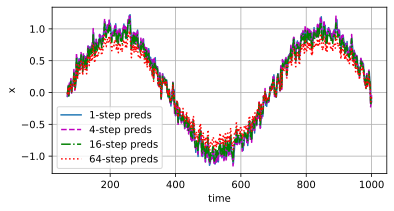

In [40]:
steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))

# Ejercicio 2: Con un valor elegido de Tau comparar resultados para la predicción de valores futuros a diferentes tiempos, graficando el error.

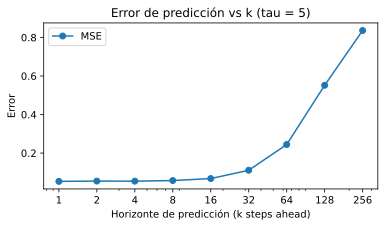

In [41]:
steps = (1, 2, 4, 8, 16, 32, 64, 128, 256)
max_k = max(steps)

preds_all = k_step_pred(max_k)

errors_mse = {}

for k in steps:
    yk = preds_all[k - 1].detach().numpy()
    start_idx = data.tau + k - 1
    y_true = data.x[start_idx : start_idx + len(yk)].detach().numpy()

    mse_k = np.mean((yk - y_true) ** 2)
    errors_mse[k] = mse_k

ks = list(errors_mse.keys())
mse_vals = [errors_mse[k] for k in ks]

plt.figure(figsize=(6, 3))
plt.plot(ks, mse_vals, 'o-', label='MSE')
plt.xscale('log')
plt.xlabel('Horizonte de predicción (k steps ahead)')
plt.ylabel('Error')
plt.title(f'Error de predicción vs k (tau = {best_tau})')
plt.legend()
plt.xticks(ks, ks)
plt.show()

Al graficar el error frente al número de pasos de predicción en el futuro, vemos que el error se mantiene relativamente constante hasta 16 pasos,
subiendo ligeramente a los 32 y aumentando significamente a partir de ese punto.

# Ejercicio 3: Realizar un análisis similar con los datos de valores de bolsa de la empresa IBM (ibm.us.txt). Extraer conclusiones. Calcular el MSE en los diferentes casos analizados.

Cargamos los datos de la empresa IBM. Y mostramos un gráfico de los valores de cierre de la bolsa a lo largo del tiempo. Esta será nuestra serie temporal.

              Open    High     Low   Close  Volume  OpenInt
Date                                                       
1962-01-02  6.4130  6.4130  6.3378  6.3378  467056        0
1962-01-03  6.3378  6.3963  6.3378  6.3963  350294        0
1962-01-04  6.3963  6.3963  6.3295  6.3295  314365        0
1962-01-05  6.3211  6.3211  6.1958  6.2041  440112        0
1962-01-08  6.2041  6.2041  6.0373  6.0870  655676        0


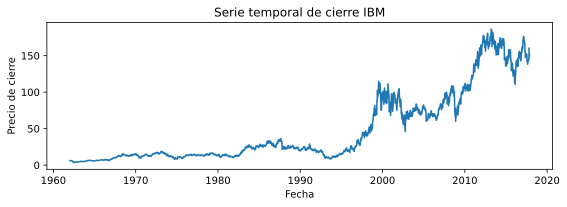

In [42]:
ibm_df = pd.read_csv("ibm.us.txt")

ibm_df["Date"] = pd.to_datetime(ibm_df["Date"])
ibm_df = ibm_df.set_index("Date")

print(ibm_df.head())

plt.figure(figsize=(8, 3))
plt.plot(ibm_df.index, ibm_df["Close"].astype("float32"))
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre")
plt.title("Serie temporal de cierre IBM")
plt.tight_layout()
plt.show()

Creamos una clase para cargar los datos de la empresa IBM. En este caso, usamos un 70% de los datos para entrenamiento, un 15% para validación y un 15% para test.

In [43]:
class IBMData(d2l.DataModule):
    def __init__(self, series, batch_size=32, train_frac=0.7, val_frac=0.15, tau=4):
        T = len(series)
        num_train = int(T * train_frac)
        num_val   = int(T * val_frac)
        num_test  = T - num_train - num_val

        self.save_hyperparameters()
        self.T = T
        self.num_train = num_train
        self.num_val = num_val
        self.num_test = num_test

        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.tensor(series, dtype=torch.float32)

        self.idx_train = slice(0, num_train)
        self.idx_val   = slice(num_train, num_train + num_val)
        self.idx_test  = slice(num_train + num_val, None)


@d2l.add_to_class(IBMData)
def get_dataloader(self, split):
    features = [self.x[i: self.T - self.tau + i] for i in range(self.tau)]
    self.features = torch.stack(features, 1)
    self.labels = self.x[self.tau:].reshape((-1, 1))

    if split == "train":
        idx = self.idx_train
        train_flag = True
    elif split == "val":
        idx = self.idx_val
        train_flag = False
    else:  # "test"
        idx = self.idx_test
        train_flag = False

    return self.get_tensorloader([self.features[idx], self.labels[idx]], train_flag)

@d2l.add_to_class(IBMData)
def train_dataloader(self):
    return self.get_dataloader("train")

@d2l.add_to_class(IBMData)
def val_dataloader(self):
    return self.get_dataloader("val")

@d2l.add_to_class(IBMData)
def test_dataloader(self):
    return self.get_dataloader("test")

In [44]:

def k_step_pred_ibm(k, data, model):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i + data.T - data.tau - k + 1])
    for i in range(k):
        preds = model(torch.stack(features[i : i + data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

In [45]:
series_ibm = ibm_df["Close"].astype("float32").values

# Normalizamos los datos
max_val = series_ibm.max()
series_ibm = series_ibm / max_val

tau_train_losses = {}
tau_val_losses = {}

loss_fn = torch.nn.MSELoss()
max_tau = 0

best_val_loss = float('inf')
best_tau = None
best_state_dict = None

for tau in range(1, max_tau):
    data = IBMData(series_ibm, tau=tau)
    train_loader = data.train_dataloader()
    val_loader   = data.val_dataloader()

    model = d2l.LinearRegression(lr=0.01)
    trainer = d2l.Trainer(max_epochs=10)
    trainer.fit(model, data)

    with torch.no_grad():
        preds_all = model(data.features)
        labels_all = data.labels

    train_idx = data.idx_train
    val_idx   = data.idx_val

    train_loss = loss_fn(preds_all[train_idx], labels_all[train_idx]).item()
    val_loss   = loss_fn(preds_all[val_idx],   labels_all[val_idx]).item()

    tau_train_losses[tau] = train_loss
    tau_val_losses[tau]   = val_loss

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_tau = tau
        best_state_dict = model.state_dict()

if max_tau > 0:
    rows = [
        {"tau": tau, "train_loss": tau_train_losses[tau], "val_loss": tau_val_losses[tau]}
        for tau in tau_train_losses
    ]
    df = pd.DataFrame(rows)
    df.to_csv("tau_losses_ibm.csv", index=False)

    with open("best_tau_ibm.txt", "w") as f:
        f.write(f"best_tau={best_tau}\nbest_val_loss={best_val_loss}\n")

    torch.save(best_state_dict, "best_model_ibm.pt")

In [46]:
df = pd.read_csv("tau_losses_ibm.csv")

taus = df["tau"].tolist()
train_losses = df["train_loss"].tolist()
val_losses   = df["val_loss"].tolist()

min_val_loss = min(val_losses)
best_val_loss = min(val_losses)
best_tau = taus[val_losses.index(best_val_loss)]

print("Mejor Tau absoluto")
print("--------------------------------")
print(f"best_tau = {best_tau}, best_val = {best_val_loss:.4f}")
print("--------------------------------\n")

alpha = 0.05
threshold = min_val_loss * (1 + alpha)

mask = df["val_loss"] <= threshold
candidates_df = df[mask]

best_row = candidates_df.loc[candidates_df["tau"].idxmin()]
best_tau = int(best_row["tau"])
best_val = float(best_row["val_loss"])

print("Tau óptimo con umbral")
print("--------------------------------")
print(f"threshold = {threshold:.4f}")
print(f"best_tau = {best_tau}, best_val = {best_val:.4f}")
print("--------------------------------")

Mejor Tau absoluto
--------------------------------
best_tau = 8, best_val = 0.0001
--------------------------------

Tau óptimo con umbral
--------------------------------
threshold = 0.0001
best_tau = 8, best_val = 0.0001
--------------------------------


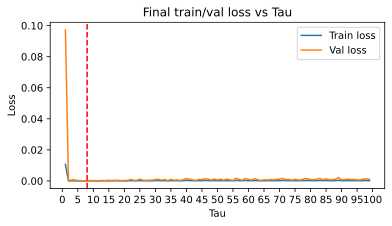

In [47]:
plt.plot(taus, train_losses, label='Train loss')
plt.plot(taus, val_losses,   label='Val loss')

plt.xlabel('Tau')
plt.ylabel('Loss')
plt.title('Final train/val loss vs Tau')
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=25))
plt.axvline(best_tau, color='red', linestyle='--', label=f'Best tau = {best_tau}')
plt.show()

En este caso, el mejor valor de tau absoluto es de 8, que coincide con el óptimo manteniendo un compromiso entre la pérdida y el valor de tau. Al ser una serie temporal más impredecible, es lógico que necesitemos más valores para la predicción.

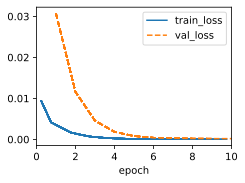

In [48]:
data = IBMData(series_ibm, tau=best_tau)
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

Calculamos el error de predicción para el conjunto de test.

In [49]:
test_loader = data.test_dataloader()

test_losses = []
with torch.no_grad():
    for X, y in test_loader:
        preds = model(X)
        test_losses.append(loss_fn(preds, y).item())
test_loss = np.mean(test_losses)
print(f"Test MSE (tau={best_tau}): {test_loss:.4f}")

Test MSE (tau=8): 0.0003


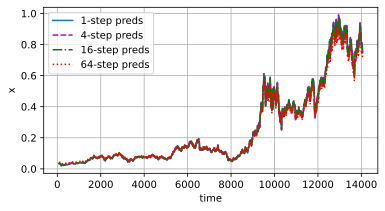

In [50]:
steps = (1, 4, 16, 64)
preds = k_step_pred_ibm(steps[-1], data, model)
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))

Graficamos las predicciones para los diferentes horizontes de predicción. Ya que nos interesa que los errores estén en la misma escala que los datos originales, calculamos el RMSE en escala real y lo expresamos como un error relativo.

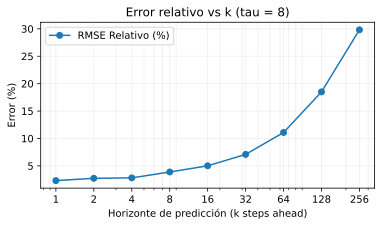

In [54]:
steps = (1, 2, 4, 8, 16, 32, 64, 128, 256)
max_k = max(steps)

preds_all = k_step_pred_ibm(max_k, data, model)

errors_relative = {}
test_start = data.idx_test.start

max_val = ibm_df["Close"].max()  # Valor usado para normalizar

for k in steps:
    yk_full = preds_all[k - 1].detach().numpy()
    pred_start_idx = data.tau + k - 1
    offset = max(0, test_start - pred_start_idx)
    yk_test = yk_full[offset:]

    # Datos reales normalizados en zona test
    y_true_test_norm = data.x[pred_start_idx + offset : pred_start_idx + offset + len(yk_test)].detach().numpy()
    
    # RMSE en dólares reales
    mse_norm = np.mean((yk_test - y_true_test_norm) ** 2)
    rmse_real = np.sqrt(mse_norm) * max_val
    
    # Precio medio real en ese periodo de test
    mean_price_real = np.mean(y_true_test_norm * max_val)
    
    # Error relativo (%) = (RMSE / Precio Medio) * 100
    relative_error_pct = (rmse_real / mean_price_real) * 100
    
    errors_relative[k] = relative_error_pct

ks = list(errors_relative.keys())
rel_vals = [errors_relative[k] for k in ks]

plt.figure(figsize=(6, 3))
plt.plot(ks, rel_vals, 'o-', label='RMSE Relativo (%)')
plt.xscale('log')
plt.xlabel('Horizonte de predicción (k steps ahead)')
plt.ylabel('Error (%)')
plt.title(f'Error relativo vs k (tau = {best_tau})')
plt.legend()
plt.xticks(ks, ks)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()


Como antes, cuanto más lejos en el futuro predecimos, mayor es el error. En este caso, para mantener el error relativo por debajo del 5% del valor de la acción, necesitamos predecir con un horizonte de menos de 16 pasos.

# Ejercicio 4: Teoría: modelos autorregresivos vs. modelos latentes autorregresivos. Busque un ejemplo que requiera variables latentes para capturar la dinámica de los datos. Explique.
Los modelos autoregresivos asumen que el futuro dependen únicamente de una ventana de datos pasada. Ejemplo: El valor de la temperatura de hoy depende del valor de la temperatura de los últimos 4 días.

Los modelos autoregresivos latentes mantienen un estado interno que se actualiza con cada paso de tiempo. Ejemplo: El valor de la temperatura de hoy depende del valor de la temperatura de los últimos 4 días y del estado interno del sistema, que puede saber si está en verano o en invierno.

Un modelo que no es latente, ante una racha de días fríos en verano, predeciría que el día siguiente será frío. Sin embargo, un modelo latente, ante la misma racha de días fríos, podría predecir que el día siguiente será caluroso, ya que mantiene en memoria el estado del sistema y sabe que está en verano.